## 10.模型微调与推理

**学习目标**

1. 熟悉模型微调的流程和方法

2. 能够针对特定任务选择合适的模型、损失函数和优化器

3. 提升调参的能力和技巧

4. 熟悉模型推理的基本流程

5. 会使用torch.load加载模型权重文件

****

### 10.1   模型微调

1. **模型微调概述**

​		业界使⽤的最⼴泛的⼤规模图像数据集之一ImageNet有超过1,000万的图像和1,000类的物体。然而，我们平常接触到的数据集的规模通常在这两者之间。假设我们想识别图⽚中不同类型的椅⼦，然后向⽤⼾推荐购买链接。⼀种可能的⽅法是⾸先识别100把普通椅⼦，为每把椅⼦拍摄 1000 张不同⻆度的图像，然后在收集的影像数据集上训练⼀个分类模型。尽管这个椅⼦数据集可能⼤于 Fashion-MNIST 数据集，但实例数量仍然不到 ImageNet 中的⼗分之⼀。这可能会导致这个椅⼦数据集上适合 ImageNet 的复杂模型过度拟合。此外，由于训练⽰例数量有限，训练模型的准确性可能⽆法满⾜实际要求。为了解决上述问题，⼀个显而易⻅的解决⽅案是收集更多的数据。但是，收集和标记数据可能需要⼤量的时间和⾦钱。例如，为了收集 ImageNet 数据集，研究⼈员从研究资⾦中花费了数百万美元。尽管⽬前的数据收集成本已⼤幅降低，但这⼀成本仍不能忽视。另⼀种解决⽅案是应⽤ 迁移学习（transfer learning）将从源数据集学到的知识迁移到⽬标数据集。例如，尽管 ImageNet 数据集中的⼤多数图像与椅⼦⽆关，但在此数据集上训练的模型可能会提取更常规的图像特征，这有助于识别边缘、纹理、形状和对象合成。这些类似的功能也可能有效地识别椅⼦。

2. **模型微调的步骤**

   在本节中，我们将介绍迁移学习中的常⻅技巧: 微调（fine-tuning）。如下图所⽰，微调包括以下四个步骤：

   （1）在源数据集上预训练神经⽹络模型，即源模型。

   （2）创建⼀个新的神经⽹络模型，即 ⽬标模型。这将复制源模型上的所有模型设计及其参数，但输出层除外。我们假定这些模型参数包含从源数据集中学到的知识，这些知识也将适⽤于⽬标数据集。我们还假设源模型的输出层与源数据集的标签密切相关；因此不在⽬标模型中使⽤该层。

   （3）向⽬标模型添加输出层，其输出数量是⽬标数据集中的类别数。然后随机初始化该层的模型参数。

   （4）在⽬标数据集（如椅⼦数据集）上训练⽬标模型。输出层将从头开始进⾏训练，而所有其他层的参数将根据源模型的参数进⾏微调。


<img src="./images/fine_tuning.png" style="zoom:60%;" />

当⽬标数据集⽐源数据集小得多时，微调有助于提⾼模型的泛化能⼒。我们在⼀个小型数据集上微调ResNet18模型，该模型已在ImageNet数据集上进⾏了预训练。

项目9：基于预训练模型微调的蝴蝶种类识别

### 10.2  数据加载和预处理

1. **导入必需的模块**

In [2]:
import time
from matplotlib import pyplot as plt

import torch
from torch import nn
from torchvision import transforms, datasets
from torchvision.models import resnet18
from torch.utils.data import DataLoader, random_split

from tools.utils import cls_fit, cls_acc, model_latency

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

2. **数据加载和预处理**

In [4]:
train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

val_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [5]:
train_dataset = datasets.ImageFolder('./datasets/butterflies and moths/train', train_transform)
val_dataset = datasets.ImageFolder('./datasets/butterflies and moths/valid', val_transform)

In [6]:
train_dataloader = DataLoader(train_dataset, 64, shuffle=True, num_workers=4, pin_memory=True)
val_dataloader = DataLoader(val_dataset, 64, shuffle=False, num_workers=4, pin_memory=True)

### 10.3  模型微调

在上一个任务中，我们构建了一个ResNet18模型并进行了训练。这里我们使用PyTorch内置的ResNet18模型通过微调的方式来训练。可以使用指令`from torchvision.models import resnet18`导入内置的ResNet18模型。

1. **模型初始化**

​		我们使⽤在 ImageNet 数据集上预训练的 Resnet18 作为源模型。预训练模型我们已经内置到平台，大家可以直接使用。预训练的源模型实例包含许多特征层和⼀个输出层 fc。此划分的主要⽬的是促进对除输出层以外所有层的模型参数进⾏微调。下⾯给出了源模型的变量 fc。在 ResNet 的全局平均池化后，全连接层汇集转换为 ImageNet 数据集的 1000 个类输出。之后，我们构建⼀个新的神经⽹络作为⽬标模型。它的定义⽅式与预训练源模型的定义⽅式相同，只是最终层中的输出数量被设置为⽬标数据集中的类数（而不是1000个）。
​		在下⾯的代码中，⽬标模型实例的变量特征中的模型参数被初始化为源模型相应层的模型参数。由于功能中的模型参数是在 ImageNet 数据集上预训练的，并且⾜够好，因此通常只需要较小的学习率即可微调这些参数。

In [7]:
# 获得训练数据集的类别
num_category = len(train_dataset.classes)
num_epochs = 10

In [8]:
# 加载预训练模型
model = resnet18()
model.load_state_dict(torch.load('./weights/resnet18-f37072fd.pth'))
model.fc.out_features = num_category  # 调整全连接层的输出数目
model = model.to(device)

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

2. **实例化损失函数（loss function)**

In [9]:
loss_func = torch.nn.CrossEntropyLoss()

3. **设置优化器（optimizer）**

In [10]:
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=0, nesterov=True)

4. **模型微调**

In [11]:
train_loss, val_loss = cls_fit(model=model, 
                               train_dataloader=train_dataloader, 
                               val_dataloader=val_dataloader,
                               epochs=num_epochs, 
                               loss_func=loss_func, 
                               optimizer=optimizer, 
                               device=device)

Epoch 1/10, Time 24.69s, Train Loss 3.29758, Val Loss 0.79781
Epoch 2/10, Time 22.49s, Train Loss 0.68481, Val Loss 0.41067
Epoch 3/10, Time 21.92s, Train Loss 0.43310, Val Loss 0.31435
Epoch 4/10, Time 21.11s, Train Loss 0.31064, Val Loss 0.26768
Epoch 5/10, Time 21.05s, Train Loss 0.24994, Val Loss 0.25358
Epoch 6/10, Time 20.85s, Train Loss 0.19904, Val Loss 0.23832
Epoch 7/10, Time 22.28s, Train Loss 0.16142, Val Loss 0.23097
Epoch 8/10, Time 22.01s, Train Loss 0.13391, Val Loss 0.20508
Epoch 9/10, Time 21.99s, Train Loss 0.11462, Val Loss 0.20851
Epoch 10/10, Time 20.77s, Train Loss 0.09729, Val Loss 0.21041


5. **绘制损失曲线**

​		对于训练过程中的loss曲线的变化，我们可以将它可视化出来。loss曲线对于模型训练情况的评估非常重要，也是我们判断模型训练是否欠拟合或者过拟合的依据。我们使用matplotlib来绘制loss曲线,并将绘制的学习曲线显示出来。

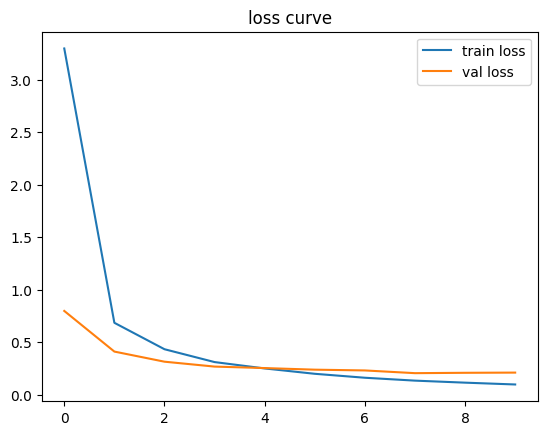

In [12]:
plt.title('loss curve')
train_loss, = plt.plot(train_loss, label='train loss')
val_loss, = plt.plot(val_loss, label='val loss')
plt.legend(handles=[train_loss, val_loss])
plt.show()

6. **验证模型精度**

​		最后，我们还需要测试下训练好的模型在整个验证集上的精度。我们可以直接调用内置的measure_accuracy函数来实现。

In [13]:
accuracy = cls_acc(model, val_dataloader, device)
print(accuracy)

0.946


7.测试模型的推理时延

In [14]:
sec = model_latency(model, device)
print(f'模型推理时延为：{sec:.6f}秒.')

模型推理时延为：0.001561秒.


8. 模型的保存

​		在前面的步骤中，我们讨论了如何加载和预处理数据，构建和训练模型，以及测试模型。当我们对所学的模型⾜够满意时，希望保存训练模型以备将来部署在各种设备中进行推理。此外，当运⾏⼀个耗时较⻓的训练过程时，最佳的做法是定期保存中间结果（检查点），以确保在服务器电源被不小⼼断掉时不会损失⼏天的计算结果。因此，我们需要知道如何加载和存储权重向量和整个模型。

​		PyTorch提供了内置函数来保存和加载整个⽹络。需要注意的是，下面的指令保存的是模型的参数而不是保存模型本身。当需要再次加载训练好的模型时，我们先要构建以前训练时的网络架构，然后加载模型参数到构建的网络中。

In [15]:
torch.save(model.state_dict(), './weights/resnet18_ft.pth')

### 10.4 模型推理

模型推理（Inference）是指使用训练好的模型对新的数据进行预测的过程。

模型推理的一般步骤为：

（1）加载模型：加载训练好的模型，包括模型架构和权重。

（2）预处理数据：对输入数据进行与训练时相同的预处理，如归一化、调整大小等。

（3）添加批次维度：PyTorch模型通常的输入数据有一个批次维度（batch dimension）。

（4）设备转移：如果使用GPU进行推理，将模型和数据转移到GPU上。

（5）模型推理：将数据通过模型进行前向传播，获取预测结果。

（6）后处理：根据模型的输出类型，进行必要的后处理。

（7）映射到标签：如果有一个从索引到实际类别标签的映射，使用索引来获取预测的类别标签。

（8）输出结果：输出或返回预测结果。

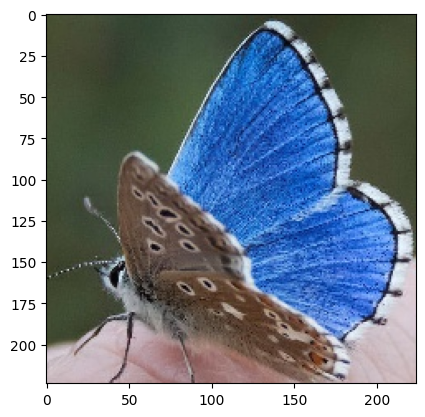

识别结果: ADONIS


In [20]:
import os
import cv2
import numpy as np
from PIL import Image

data_path = './datasets/butterflies and moths/valid'

# （1）加载模型
model = resnet18()
model.load_state_dict(torch.load('./weights/resnet18_ft.pth'))
model.fc.out_features = num_category  # 调整全连接层的输出数目
model = model.to(device)  # (4) 设备转移（模型）

# （7）类别标签
label_cls = [folder for folder in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, folder))]

# （2）预处理数据
image = cv2.imread("./datasets/butterflies and moths/test/ADONIS/2.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()

img = Image.fromarray(image)
img = val_transform(img).unsqueeze(0).to(device)  # (3) 添加批次维度  (4) 设备转移（数据）

# （5）模型推理
model.eval()
output = model(img)

# （6）后处理
predicted_index = torch.argmax(output, dim=1).cpu().item()  # 获取预测的类别索引

# （7）映射到类别标签  （8）输出结果
print(f"识别结果: {label_cls[predicted_index]}")

### 10.4   小结

1. 迁移学习将从源数据集中学到的知识“迁移”到⽬标数据集，微调是迁移学习的常⻅技巧。
2. 除输出层外，⽬标模型从源模型中复制所有模型设计及其参数，并根据⽬标数据集对这些参数进⾏微调。但是，⽬标模型的输出层需要从头开始训练。
3. 微调参数使⽤较小的学习率，而从头开始训练输出层可以使⽤更⼤的学习率。
4. save和load函数可⽤于张量对象的⽂件读写；我们可以通过参数字典保存和加载⽹络的全部参数；保存结构必须在代码中完成，而不是在参数中完成。